In [25]:
from transformers import RobertaModel, RobertaTokenizer, DataCollatorWithPadding
from transformers import get_scheduler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm


In [ ]:
# checkpoint = '/root/autodl-tmp/cache'
class RobertaBilstmClassifier(nn.Module):
    def __init__(self,checkpoint='roberta-base', num_classes=3, hidden_size=32):
        super(RobertaBilstmClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained(checkpoint)
        
        self.dropout = nn.Dropout(0.3)
        self.lstm = nn.LSTM(input_size=self.roberta.config.hidden_size, 
                            hidden_size=hidden_size, 
                            bidirectional=True, 
                            batch_first=True,
                            dropout=0.2,
                            )
        self.fc1 = nn.Linear(hidden_size * 2, 32) # Multiply by 2 for bidirectional LSTM
        self.activation = nn.SiLU()  #Swish activation
        self.fc2 = nn.Linear(32, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        roberta_output = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        sequence_output = roberta_output.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)

        # sequence_output = self.dropout(sequence_output) # first dropout

        lstm_output, _ = self.lstm(sequence_output)
        lstm_output = lstm_output[:, -1, :]

        # lstm_output = self.dropout(lstm_output)# second dropout

        fc1_output = self.fc1(lstm_output)

        fc1_output = self.activation(fc1_output)

        # fc1_output = self.dropout(fc1_output) # third dropout

        fc2_output = self.fc2(fc1_output)

        output = self.softmax(fc2_output)
        return output


In [4]:
# Load dataset
# df = pd.read_csv("/root/autodl-tmp/remotefolder/cleaned_tweet_80k.csv")
raw_datasets = load_dataset("csv",data_files="/root/autodl-tmp/remotefolder/cleaned_tweet_9k.csv")
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['class', 'tweet'],
        num_rows: 8664
    })
})

In [5]:
unique_labels = list(set(raw_datasets['train']['class']))
unique_labels

['BIPOLAR', 'DEPRESSION', 'ADHD']

In [6]:
from datasets import ClassLabel
raw_datasets = raw_datasets.rename_column("class","labels")
raw_datasets = raw_datasets.cast_column('labels',ClassLabel(names=unique_labels))
raw_datasets['train'][0]

{'labels': 2,
 'tweet': 'people should always come before profits because ultimately its people who create the profits httpurl '}

In [7]:
splited_datasets = raw_datasets['train'].train_test_split(train_size=0.8,seed=42)
splited_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'tweet'],
        num_rows: 6931
    })
    test: Dataset({
        features: ['labels', 'tweet'],
        num_rows: 1733
    })
})

In [8]:
checkpoint = '/root/autodl-tmp/cache'
# checkpoint = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example['tweet'], truncation=True)

tokenized_datasets = splited_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'tweet', 'input_ids', 'attention_mask'],
        num_rows: 6931
    })
    test: Dataset({
        features: ['labels', 'tweet', 'input_ids', 'attention_mask'],
        num_rows: 1733
    })
})

In [9]:
print(tokenized_datasets['train'][0]['tweet'])
input_ids = tokenized_datasets['train'][0]['input_ids']
print(input_ids)
print(tokenized_datasets['train'][0]['attention_mask'])
decode_token = tokenizer.convert_ids_to_tokens(input_ids)
print(decode_token)

 shares what the great reimagination means for the future of work read all about it here httpurl 
[0, 327, 99, 5, 372, 26585, 1073, 8111, 839, 13, 5, 499, 9, 173, 1166, 70, 59, 24, 259, 2054, 6423, 1437, 2]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
['<s>', 'Ġshares', 'Ġwhat', 'Ġthe', 'Ġgreat', 'Ġreim', 'ag', 'ination', 'Ġmeans', 'Ġfor', 'Ġthe', 'Ġfuture', 'Ġof', 'Ġwork', 'Ġread', 'Ġall', 'Ġabout', 'Ġit', 'Ġhere', 'Ġhttp', 'url', 'Ġ', '</s>']


In [10]:
tokenized_datasets = tokenized_datasets.remove_columns(['tweet'])
tokenized_datasets.set_format('torch')
tokenized_datasets['train'].column_names

['labels', 'input_ids', 'attention_mask']

In [11]:
train_dataloader = DataLoader(
    tokenized_datasets['train'],shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets['test'], batch_size=8, collate_fn=data_collator
)

In [12]:
for batch in train_dataloader:
    break
{k:v.shape for k, v in batch.items()}

{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 55]),
 'attention_mask': torch.Size([8, 55])}

In [13]:
# Set up model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RobertaBilstmClassifier(num_classes=3, checkpoint=checkpoint, hidden_size=32)
model = model.to(device)
device
# # Print model summary
# def count_parameters(model):
#         return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
# print("Model Architecture:")
# print(model)
# print(f"\nTrainable parameters: {count_parameters(model):,}")

Some weights of RobertaModel were not initialized from the model checkpoint at /root/autodl-tmp/cache and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


device(type='cuda')

In [14]:
optimizer_paramters = [
    {
        'params':model.roberta.parameters(),
        'lr':1e-5
    },
    {
        'params':[p for n, p in model.named_parameters() if not n.startswith('roberta')],
        'lr':1e-4
    }
]
optimizer = torch.optim.AdamW(optimizer_paramters)
print(optimizer)




AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-05
    maximize: False
    weight_decay: 0.01

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.01
)


In [15]:
num_epochs = 10

num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)
print(num_training_steps)

8670


In [ ]:
criterion = nn.CrossEntropyLoss()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
for epoch in range(num_epochs):
    progress_bar = tqdm.notebook.tqdm(range(len(train_dataloader)), desc=f"[epoch{epoch+1}/epochs{num_epochs}]")
    model.train()
    train_total_loss = 0
    train_correct = 0
    train_total = 0
    
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(batch['input_ids'], batch['attention_mask'])
        
        train_loss = criterion(outputs, batch['labels'])

        train_loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
     

        train_total_loss +=train_loss.item()

        _, preds = outputs.max(1)
        train_correct += torch.sum(preds == batch["labels"]).cpu()

        train_total +=batch["labels"].size(0)
        progress_bar.set_postfix({'train_loss': f'{train_loss.item():.4f}', 'train_accuracy': f'{train_correct/train_total:.4f}'})
        progress_bar.update(1)
    
    train_avg_loss = train_total_loss / len(train_dataloader)
    train_avg_accuracy = train_correct / train_total
    train_losses.append(train_avg_loss)
    train_accuracies.append(train_avg_accuracy)


    model.eval()
    eval_total_loss = 0
    eval_correct_predictions = 0
    eval_total = 0

    with torch.no_grad():
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(batch['input_ids'], batch['attention_mask'])
            eval_loss = criterion(outputs,batch['labels'])

            eval_total_loss += eval_loss.item()
            _, preds = outputs.max(1)
            eval_correct_predictions += torch.sum(preds == batch["labels"]).cpu()
            eval_total +=batch["labels"].size(0)

    eval_avg_loss = eval_total_loss / len(eval_dataloader)
    eval_avg_accuracy = eval_correct_predictions / eval_total
    val_losses.append(eval_avg_loss)
    val_accuracies.append(eval_avg_accuracy)
    progress_bar.set_postfix({'train_loss': f'{train_avg_loss:.4f}', 'training_accuracy': f'{train_avg_accuracy:.4f}',
                              'Val_loss': f'{eval_avg_loss:.4f}', 'Val_accuracy': f'{eval_avg_accuracy:.4f}'})

    


[epoch 1/ epochs 10]:   0%|          | 0/867 [00:00<?, ?it/s]

[epoch 2/ epochs 10]:   0%|          | 0/867 [00:00<?, ?it/s]

[epoch 3/ epochs 10]:   0%|          | 0/867 [00:00<?, ?it/s]

[epoch 4/ epochs 10]:   0%|          | 0/867 [00:00<?, ?it/s]

[epoch 5/ epochs 10]:   0%|          | 0/867 [00:00<?, ?it/s]

[epoch 6/ epochs 10]:   0%|          | 0/867 [00:00<?, ?it/s]

[epoch 7/ epochs 10]:   0%|          | 0/867 [00:00<?, ?it/s]

[epoch 8/ epochs 10]:   0%|          | 0/867 [00:00<?, ?it/s]

[epoch 9/ epochs 10]:   0%|          | 0/867 [00:00<?, ?it/s]

[epoch 10/ epochs 10]:   0%|          | 0/867 [00:00<?, ?it/s]

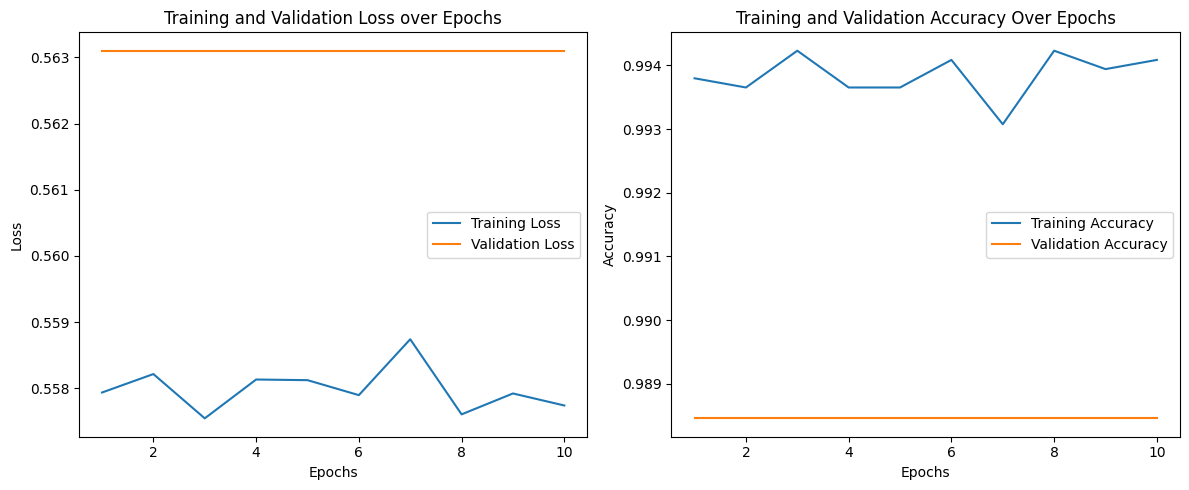

In [27]:
# Plotting training loss and accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1,num_epochs +1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label ='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


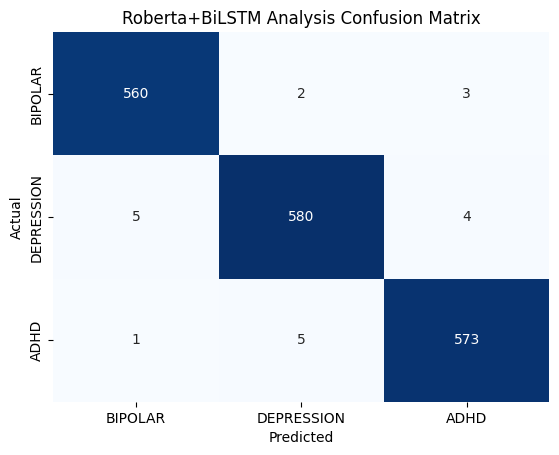

              precision    recall  f1-score   support

     BIPOLAR       0.99      0.99      0.99       565
  DEPRESSION       0.99      0.98      0.99       589
        ADHD       0.99      0.99      0.99       579

    accuracy                           0.99      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       0.99      0.99      0.99      1733



In [28]:
# Evaluation
# metric = evaluate.load("accuracy")
model.eval()

all_predictions = []
all_labels = []

for batch in eval_dataloader:
    batch = {k: v.to(device) for k,v in batch.items()}
    with torch.no_grad():
        outputs = model(batch['input_ids'],batch['attention_mask'])
    
    _, predictions = outputs.max(1)

    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(batch["labels"].cpu().numpy())

    # metric.add_batch(predictions=predictions, References=batch["labels"])

# results = metric.compute()
# print("Evaluation Results:", results)

conf_matrix = confusion_matrix(all_labels, all_predictions)
# labels=["ADHD", "BIPO", "DEP"]
fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', cbar=False)
ax.xaxis.set_ticklabels(unique_labels)
ax.yaxis.set_ticklabels(unique_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Roberta+BiLSTM Analysis Confusion Matrix')
plt.show()

print(classification_report(all_labels, all_predictions, target_names=unique_labels))